In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# BCE classifier

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn as nn
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,1),  nn.Sigmoid())
init_net(net)

In [ ]:
model = ModelWrapper(net)

data, test = get_paper_data(200000, bm=0, bs=32, n_test=1000000)

model.fit(200, data=data, opt=partialler(optim.SGD,lr=2e-3), loss=nn.BCELoss(),
          cbs=[LossTracker(),EarlyStopping(5)])

torch.save({'model':model.model.state_dict()}, 'weights/BCE_Test.h5')

In [ ]:
state = torch.load('weights/BCE_Test.h5', map_location='cpu')

In [ ]:
model.model.load_state_dict(state['model'])

<All keys matched successfully>

## BM 0

In [ ]:
preds = model.predict(test)

In [ ]:
preds

array([[8.6434996e-01],
       [7.9258597e-01],
       [9.4368440e-01],
       ...,
       [2.7419845e-05],
       [6.3692492e-01],
       [6.9586283e-01]], dtype=float32)

In [ ]:
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0.864350,1.0
1,0.792586,1.0
2,0.943684,1.0
3,0.890150,1.0
4,0.847149,1.0


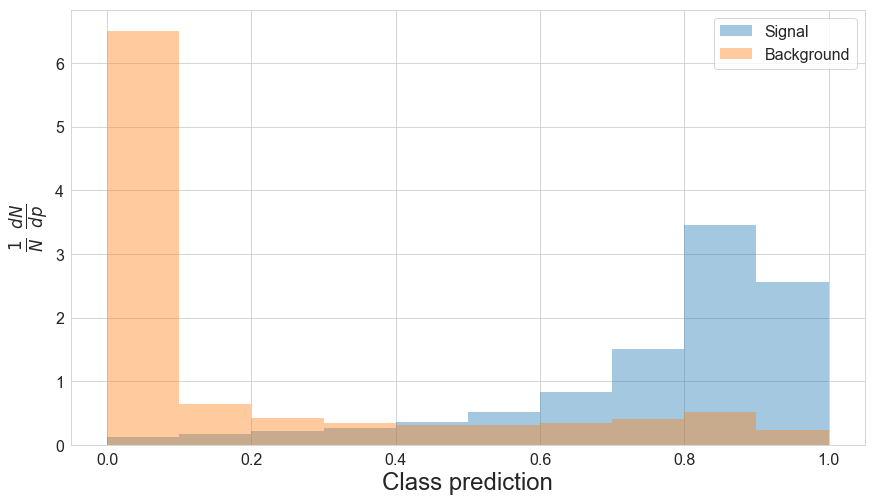

In [ ]:
plot_preds(df)

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,0.864350,1.0,8
1,0.792586,1.0,7
2,0.943684,1.0,9
3,0.890150,1.0,8
4,0.847149,1.0,8


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [ ]:
f_s, f_b

(tensor([0.0118, 0.0167, 0.0210, 0.0267, 0.0360, 0.0521, 0.0828, 0.1511, 0.3457,
         0.2561]),
 tensor([0.6510, 0.0635, 0.0416, 0.0335, 0.0305, 0.0312, 0.0338, 0.0403, 0.0519,
         0.0226]))

In [ ]:
t_exp = (50*f_s)+(1000*f_b)

In [ ]:
t_exp, t_exp.sum()

(tensor([651.6343,  64.3829,  42.6478,  34.8573,  32.2641,  33.7604,  37.9785,
          47.8827,  69.2205,  35.3714]), tensor(1050.))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+((n-m)*f_b))
    y[i] = -pois.log_prob(t_exp).sum()
y -= y.min()

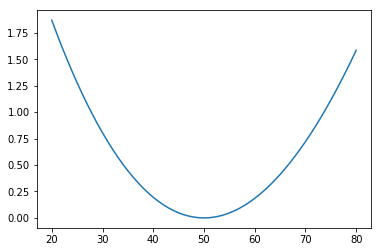

In [ ]:
plt.plot(x,y)

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [ ]:
r = InterpolatedUnivariateSpline(x, y-0.5).roots()

In [ ]:
(r[1]-r[0])/2

16.230630409986322

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_syst_shapes(bkg, df, model=model)

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0.864350,1.0,8,0.864350,8,0.864350,8,0.864350,8,0.864350,8,0.864350,8
1,0.792586,1.0,7,0.792586,7,0.792586,7,0.792586,7,0.792586,7,0.792586,7
2,0.943684,1.0,9,0.943684,9,0.943684,9,0.943684,9,0.943684,9,0.943684,9
3,0.890150,1.0,8,0.890150,8,0.890150,8,0.890150,8,0.890150,8,0.890150,8
4,0.847149,1.0,8,0.847149,8,0.847149,8,0.847149,8,0.847149,8,0.847149,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.352001,0.0,3,0.316567,3,0.352001,3,0.384074,3,0.419305,4,0.273740,2
999996,0.167930,0.0,1,0.231006,2,0.167930,1,0.123581,1,0.179008,1,0.164484,1
999997,0.000027,0.0,0,0.000034,0,0.000027,0,0.000022,0,0.000035,0,0.000020,0
999998,0.636925,0.0,6,0.700043,7,0.636925,6,0.570970,5,0.640021,6,0.635640,6


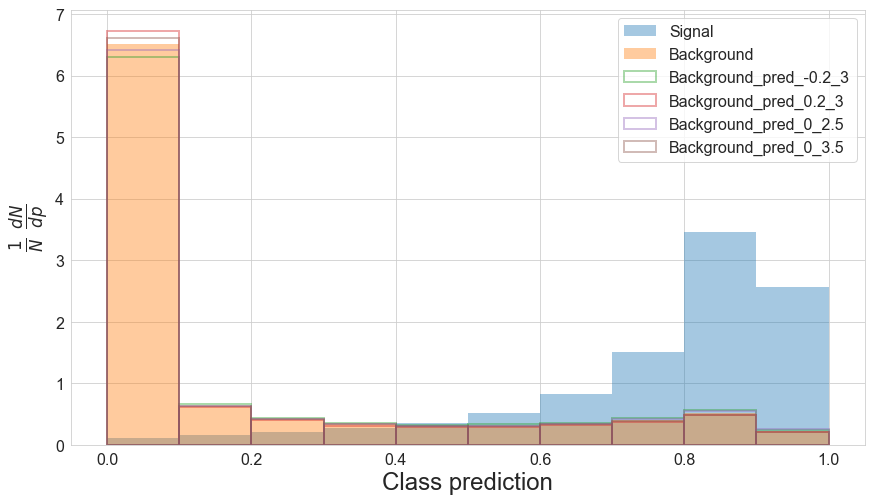

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'])

In [ ]:
nll = likelihood_from_updw(f_s=f_s, **b_shapes)

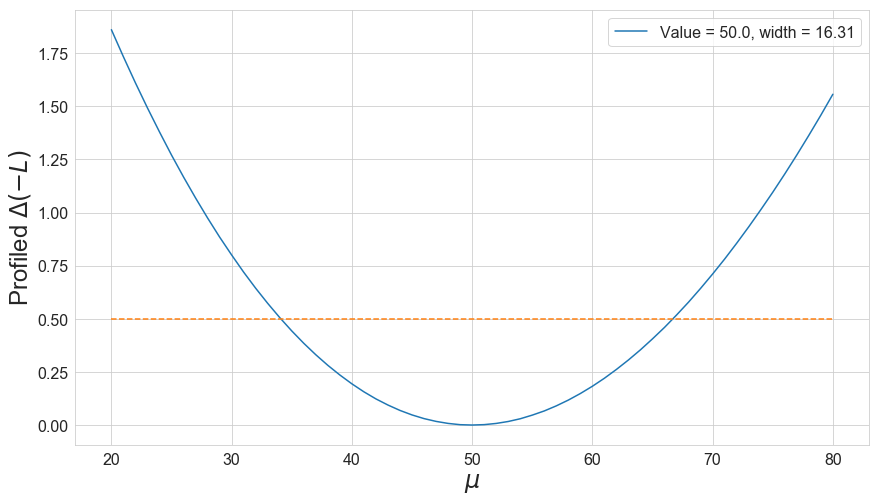

In [ ]:
plot_likelihood(nll-nll.min())